In [1]:
import os
import warnings

warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

In [2]:
source = 'sample_data/'

In [2]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from Mask_RCNN.mrcnn.utils import Dataset

import numpy as np
 
# class that defines and loads the dataset
# Dataset is a parent!!!
class GetDataset(Dataset):
    
    # load the dataset definitions
    def load_dataset(self, dataset_name):
        
        # 1 == the number of classes (not including background), 
        # dataset_name is to help keep track of what the instance of the
        # class is holding. In this case it's "sand_dollar"
        self.add_class('dataset', 1, dataset_name)
    
        # Will need to change this when we have the 
        # real dataset
        source = 'sample_data/'
        
        # Goes through all of the folder, records the basename of each file
        # then knowing that each the filenames are the same, just concats the suffix
        # to the basename, then appends each to their respective arrays
        
        # !!! Change to use glob instead of os !!!
        for file in os.listdir(source):
            
            # makes it so that we only loop through once and twice (i.e. creating duplicates)
            if(".orig.xml" in file):

                filename = file.split(".orig")[0]
                image_ids = filename

                xml_path =source + filename + ".orig.xml"

                image_path = source + filename + ".orig.jpg"
                
                self.add_image('dataset', image_id = image_ids, path = image_path, annotation = xml_path)        
            
    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        
        # load and parse the file
        tree = ElementTree.parse(filename)
        
        # get the root of the document
        root = tree.getroot()
        
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        
        return boxes, width, height
 
    # load the masks for an image
    def load_mask(self, image_id):
        
        # get details of image
        info = self.image_info[image_id]
        
        # define box file location
        path = info['annotation']
        
        # load XML
        boxes, w, h = self.extract_boxes(path)
        
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('sand_dollar'))
        return masks, asarray(class_ids, dtype='int32')
 
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [3]:
dataset_name = 'sand_dollar'

# train set
train_set = GetDataset()
train_set.load_dataset(dataset_name)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
 
# test/val set
test_set = GetDataset()
test_set.load_dataset(dataset_name)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 29
Test: 29


In [4]:
# Just a display of a image and a annotation
import matplotlib.pyplot as plt

index = np.random.randint(len(train_set.image_ids))

image = train_set.load_image(index)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(index)
print(mask.shape)
# plot image
plt.imshow(image)
# plot mask
plt.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
plt.show()

(1024, 1360, 3)
(1024, 1360, 1)


<Figure size 640x480 with 1 Axes>

In [5]:
# Gives a view of what's going on in the object we created
def sanity_check(dataset):
    for image_id in dataset.image_ids:
        # load image info
        info = dataset.image_info[image_id]
        # display on the console
        print(info)
        
#sanity_check(train_set)

sample_data/201503.20150602.121647953.69138.orig.jpg
Number of annotations: 210


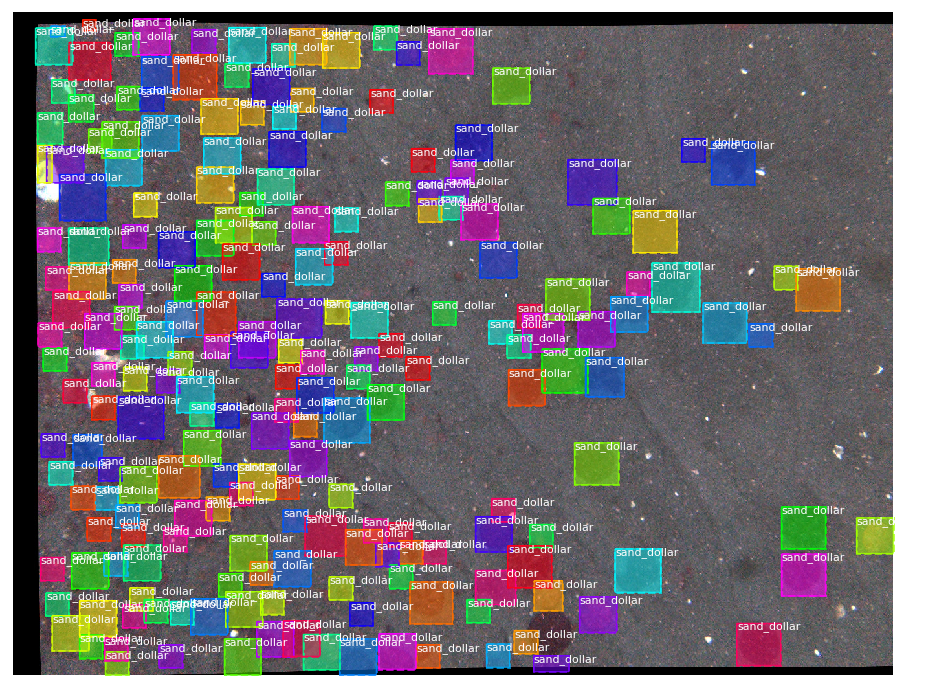

In [6]:
# Provides a better display of a image, and ALL of the annotations for said image
# takes a bit of time, blame the original repo, but at least it's pretty :)

from Mask_RCNN.mrcnn.visualize import display_instances
from Mask_RCNN.mrcnn.utils import extract_bboxes
# in visualize.py, change line 28 to "from Mask_RCNN.mrcnn import utils" :)

# define image id
index = 5

print(train_set.image_reference(index))

# load the image
image = train_set.load_image(index)

# load the masks and the class ids
mask, class_ids = train_set.load_mask(index)

# extract bounding boxes from the masks
bbox = extract_bboxes(mask)

print("Number of annotations:", mask.shape[2])
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [7]:
from Mask_RCNN.mrcnn.config import Config

# define a configuration for the training process
# can change the configure file, see the original
# MaskRCNN repo for details about different hyperparameters!

# Will need everyone's help figuring out the hyperparameters!
class TrainConfig(Config):
   
    # define the name of the configuration
    NAME = "sand_dollar_config"
    
    IMAGES_PER_GPU = 1
    
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    
    # number of training steps per epoch
    STEPS_PER_EPOCH = len(train_set.image_ids)
    
    IMAGE_MIN_DIM = 128
    
    IMAGE_MAX_DIM = 128
    
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    
    
training_config = TrainConfig()

In [8]:
from Mask_RCNN.mrcnn.model import MaskRCNN
# Change line 29 in model.py to "from Mask_RCNN.mrcnn import utils"

training_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

Using TensorFlow backend.


image_id:  sample_data/201503.20150602.121647953.69138.orig.jpg
Original shape:  (1024, 1360, 3)
New shape: (128, 128, 3)


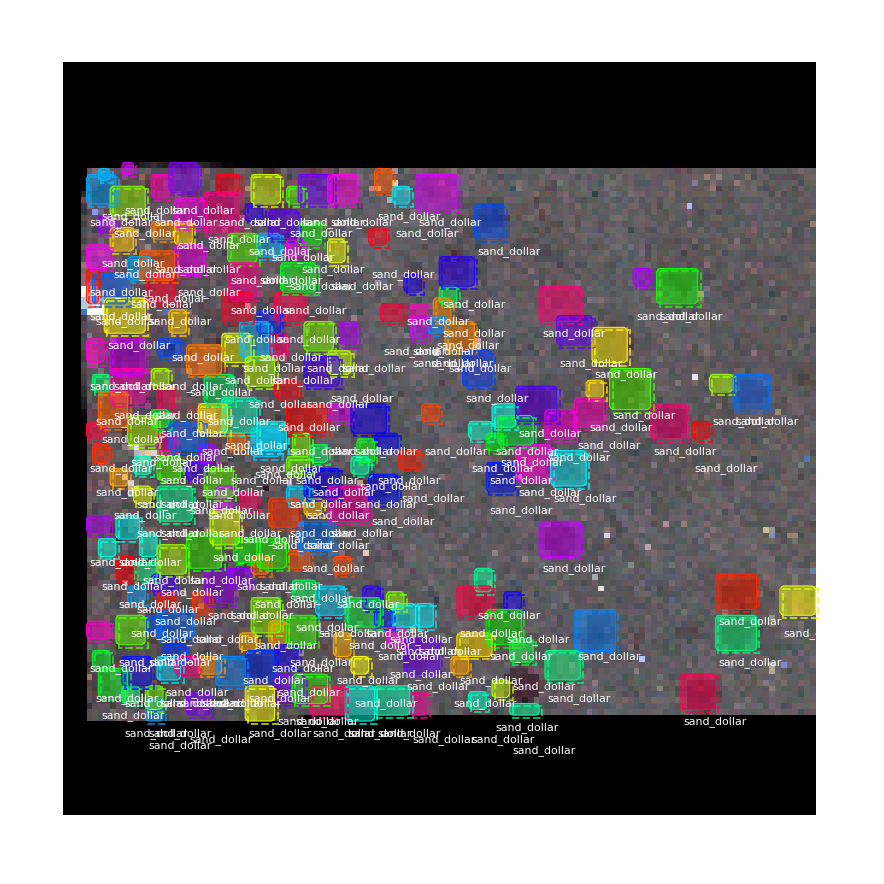

In [9]:
# Resizing training images and mask based on the details in the config file
from Mask_RCNN.mrcnn import utils, visualize

image = train_set.load_image(index)
mask, class_ids = train_set.load_mask(index)
original_shape = image.shape

# Resize
image, window, scale, padding, crop = utils.resize_image(image, min_dim=training_config.IMAGE_MIN_DIM, max_dim=training_config.IMAGE_MAX_DIM)

mask = utils.resize_mask(mask, scale, padding)

# Compute Bounding box
bbox = utils.extract_bboxes(mask)


# Display image and additional stats
print("image_id: ", train_set.image_reference(index))
print("Original shape: ", original_shape)
print("New shape:", image.shape)

# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [10]:
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=training_config)

# load weights (mscoco) and exclude the output layers
model.load_weights('./mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=training_config.LEARNING_RATE, epochs=5, layers='heads')

Instructions for updating:
Colocations handled automatically by placer.


OSError: Unable to open file (truncated file: eof = 77594624, sblock->base_addr = 0, stored_eof = 257557808)